In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [5]:
def main(config):
    logger = config.get_logger('train')

    # setup data_loader instances
    data_loader = config.init_obj('data_loader', module_data)
    valid_data_loader = data_loader.split_validation()

    # build model architecture, then print to console
    model = config.init_obj('arch', module_arch)
    logger.info(model)

    # get function handles of metrics
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer.
    optimizer = config.init_obj('optimizer', pyro.optim)

    # build trainer
    # kwargs = config['trainer'].pop('args')
    trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                              config=config, data_loader=data_loader,
                              valid_data_loader=valid_data_loader,
                              lr_scheduler=None)

    return trainer

In [6]:
from utils import read_json

config = read_json("experiments/ppc_minibmnist_config.json")
config = ConfigParser(config)
trainer = main(config)
trainer._resume_checkpoint("saved/models/MiniBouncingMnist_Ppc/0402_162552/checkpoint-epoch170.pth")

BouncingMnistPpc(
  (decoder): DigitsDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=400, bias=True)
      (3): ReLU()
      (4): Linear(in_features=400, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (digit_features): DigitFeatures()
  (digit_positions): DigitPositions()
  (graph): PpcGraphicalModel()
)
Trainable parameters: 396984
Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize particles: train batch 2
Initialize particles: train batch 3
Initialize particles: train batch 4
Initialize particles: train batch 5
Initialize particles: train batch 6
Initialize particles: train batch 7
Initialize particles: train batch 8
Initialize particles: train batch 9
Initialize particles: train batch 10
Initialize particles: train batch 11
Initialize particles: train batch 12
Initialize particles: train batch 13
Initialize particles: tra

In [7]:
trainer.model.eval()
trainer.cpu()
trainer.valid_particles.cpu()

ParticleDict(
    (z_what): Parameter containing: [torch.FloatTensor of size 10x100x3x10]
    (z_where__0): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__1): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__2): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__3): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__4): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__5): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__6): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__7): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__8): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
    (z_where__9): Parameter containing: [torch.FloatTensor of size 10x100x3x2]
)

In [8]:
trainer._load_particles(range(trainer.data_loader.batch_size), False)

In [9]:
import matplotlib.pyplot as plt

In [10]:
xs, target, index = trainer.data_loader.dataset[0]

In [11]:
xs.shape

torch.Size([10, 96, 96])

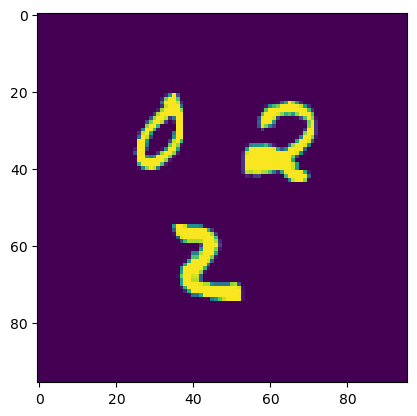

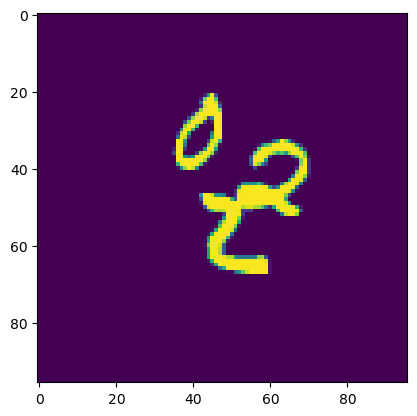

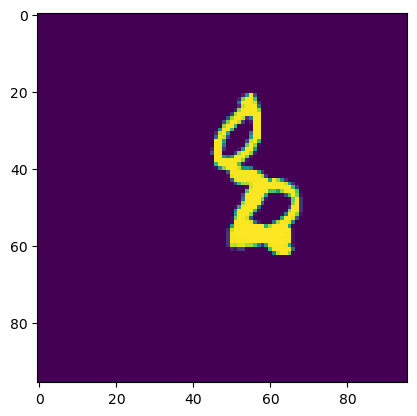

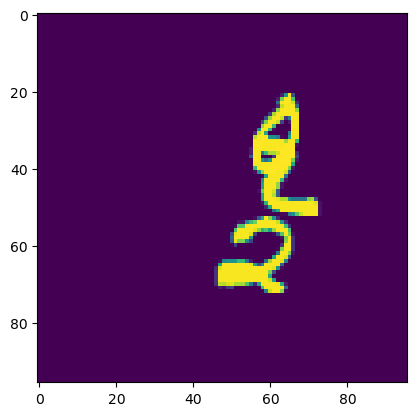

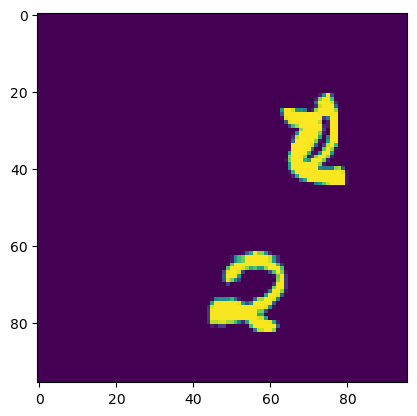

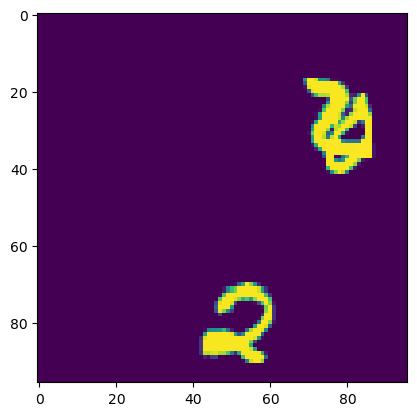

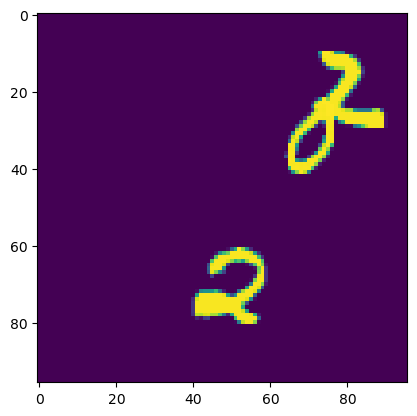

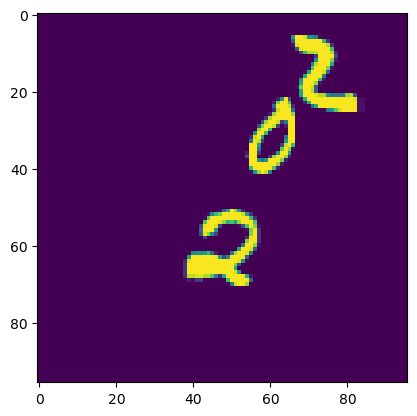

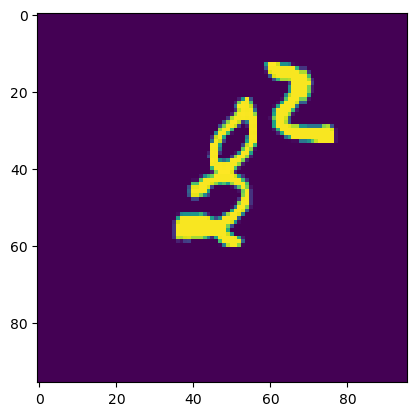

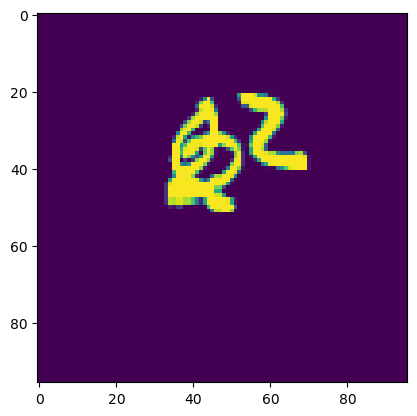

In [12]:
for t in range(xs.shape[0]):
    plt.imshow(xs[t, :, :])
    plt.show()

In [13]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [14]:
with pyro.plate_stack("forward", (trainer.num_particles, trainer.data_loader.batch_size)):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    estimates = model()

In [15]:
estimate = estimates.mean(dim=0)[0]

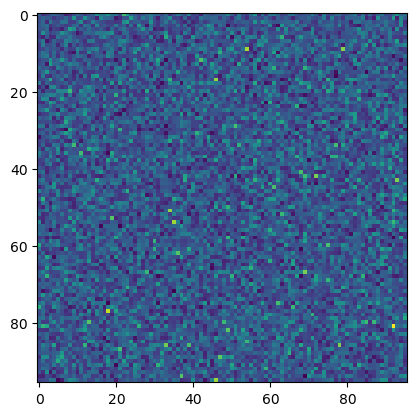

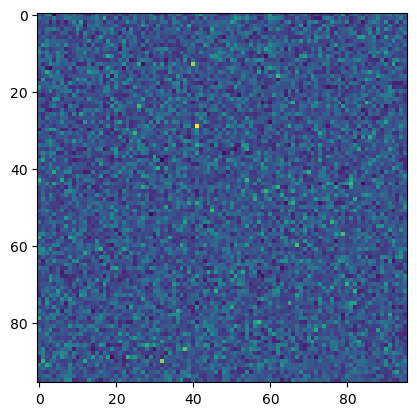

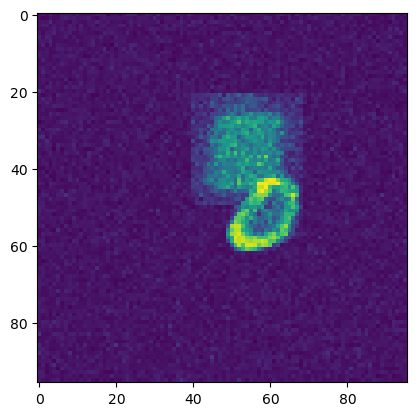

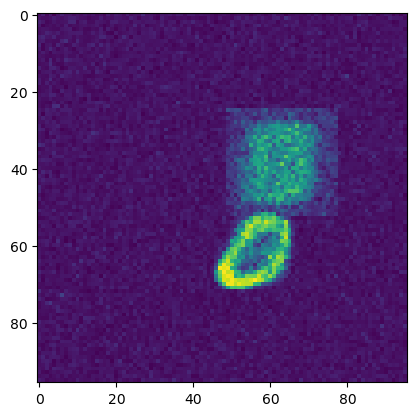

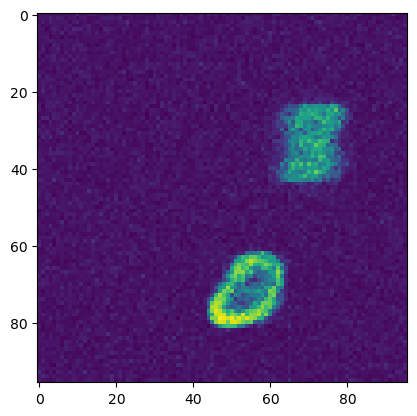

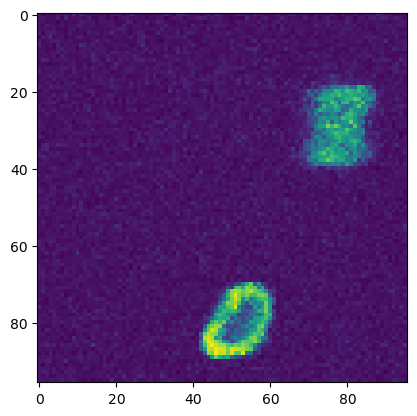

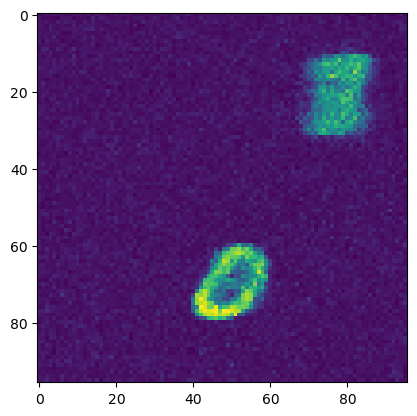

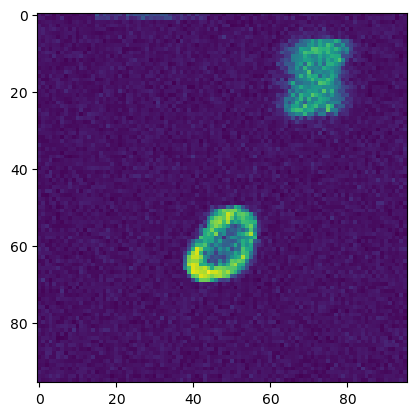

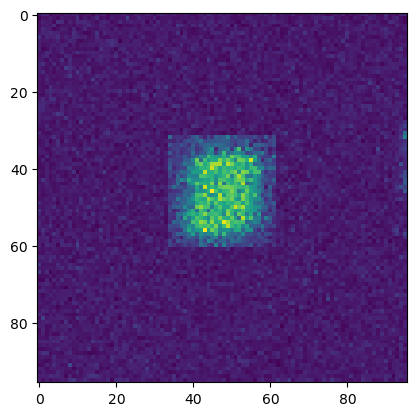

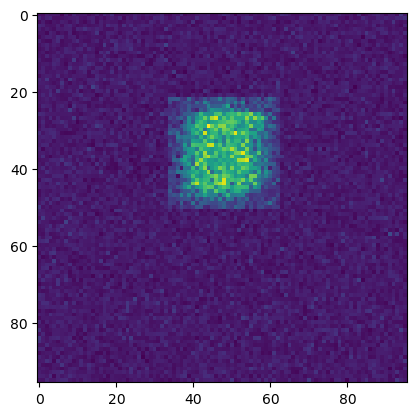

In [16]:
for t in range(estimate.shape[0]):
    plt.imshow(estimate[t, :, :].detach().numpy())
    plt.show()